<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*FAN HUANG*]
### ***username***: [*acse-fh223*]
### ***CID***: [*01883792*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

Choose **VAE** for this training task.
*   VAE training is usually more stable compared to GAN.
*   VAEs are usually structurally simpler than GANs, which can lead to shorter training times for VAEs in some cases.

For our dataset this time, VAE should be able to complete the image generation function while completing the model training in a much shorter time. This may be more suitable for the time-limited challenges we face.



## Data preparation

Import the data we need from Google Drive.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the Python libraries that will be used in our task.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import GaussianBlur
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Install livelossplot for plotting loss functions.
!pip install livelossplot
from livelossplot import PlotLosses

import os


Check if our GPU is available.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU available: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

GPU available: Tesla V100-SXM2-16GB


In [4]:
# Design custom functions that access our dataset to get data.
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# Define transform
transform = transforms.Compose([
    # Resize images and use interpolation to fill in the blanks
    transforms.Resize((32, 32), interpolation=InterpolationMode.BICUBIC),
    # Adding a Gaussian filter reduces the effect of noise
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5)),
    # Converting images to PyTorch tensors
    transforms.ToTensor()
])

# Creating a CustomImageDataset instance
dataset = CustomImageDataset('/content/drive/MyDrive/dlmodule-coursework-1-acse-fh223/real_hands', transform=transform)

batch_size = 200
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Looking at some of the samples in our dataset helps us understand the dataset.

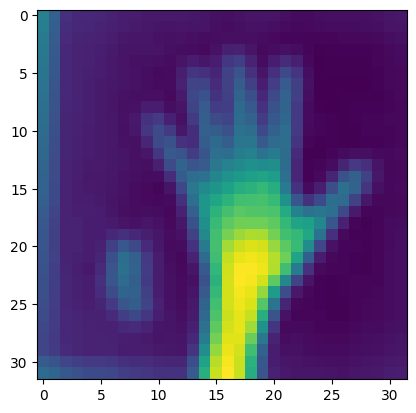

number of batches = 40
number of images = 8000


In [5]:
# Getting a batch of images
images = next(iter(dataloader))

# Show first image
plt.imshow(images[0].permute(1, 2, 0))  # Adjusting channel order for matplotlib
plt.show()

# Number of batches and number of images
print('number of batches = '+str(len(dataloader)))
print('number of images = '+str(len(dataset)))

## Network design and implementation

Define Encoder for VAE.

In [6]:
class Encoder(nn.Module):
  def __init__(self):

    super(Encoder, self).__init__()
    self.layer0 = nn.Linear(1024, 512)  # Image to hidden, fully connected
    self.transform0 = nn.ReLU()
    self.layer1 = nn.Linear(512, 256)  # Image to hidden, fully connected
    self.transform1 = nn.ReLU()

  def forward(self, x):

    x = torch.flatten(x, start_dim = 1)  # Reshape the input into a vector (nD to 1D)
    x = self.transform0(self.layer0(x))  # Run Image through Linear transform then ReLu activation function
    x = self.transform1(self.layer1(x))  # Run Image through Linear transform then ReLu activation function
    return x


Define Decoder for VAE.

In [7]:
class Decoder(nn.Module):
  def __init__(self):

    super(Decoder, self).__init__()
    self.layer1 = nn.Linear(256, 512)  # Connectivity Latent to Hidden
    self.activation1 = nn.ReLU()
    self.layerOut = nn.Linear(512, 1024)  # Connectivity Hidden to Image
    self.activationOut = nn.Sigmoid()

  def forward(self, z):

    z = self.activation1(self.layer1(z))  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,32,32))  # Reshape the vector into an image


Define the structure and loss function of the VAE.

In [8]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent):
    '''
    Class combines the Encoder and the Decoder.

    dims_latent: [int] the dimension of (number of nodes in) the mean-field gaussian latent variable
    '''

    super(VariationalAutoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

    self.layerMu = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.layerSig = nn.Linear(256, dims_latent)  # Hidden to latent, fully connected
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)

    self.latentOut = nn.Linear(dims_latent, 256)  # Connectivity Latent to Hidden
    self.activationOut = nn.ReLU()


  def vae_latent_space(self, x):
    mu =  self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures positivity for Sigma
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x):
    x = self.encoder(x)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))  # Take the latent vector and make the input for the Decoder
    return self.decoder(z), kl_div


## Training and evaluation loops

Define the training loop, including the loss statistic and livelossplot.

In [9]:
def train(autoencoder, data, kl_div_on=True, epochs=20):
    # Using the Adam Optimiser
    opt = torch.optim.Adam(autoencoder.parameters())
    liveloss = PlotLosses()  # Creating a livelossplot object

    for epoch in range(epochs):
        logs = {}
        total_loss = 0

        for batch in data:
            batch = batch.to(device)
            opt.zero_grad()
            x_hat, KL = autoencoder(batch)
            loss = ((batch - x_hat)**2).sum() + KL
            loss.backward()
            opt.step()
            total_loss += loss.item()

        average_loss = total_loss / len(data.dataset)

        # Update livelossplot's log
        logs['loss'] = average_loss
        liveloss.update(logs)
        liveloss.send()  # Send logs to update charts

        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

    return autoencoder


## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

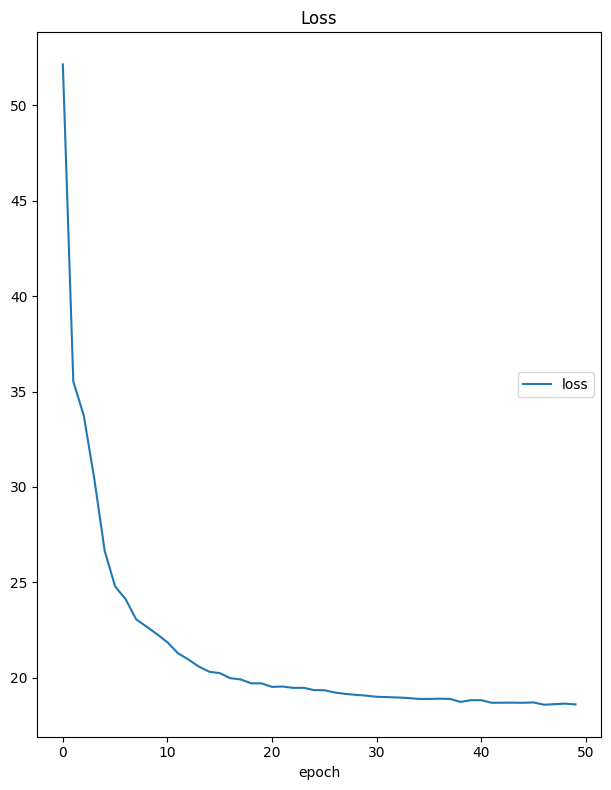

Loss
	loss             	 (min:   18.580, max:   52.152, cur:   18.595)
Epoch 50/50, Loss: 18.594509613037108


In [16]:
dims_latent = 3
VAE = VariationalAutoencoder(dims_latent).to(device)
VAE = train(VAE, dataloader, epochs=50)

## Generate 300 new samples with your trained network

Showing the images generated by our model.

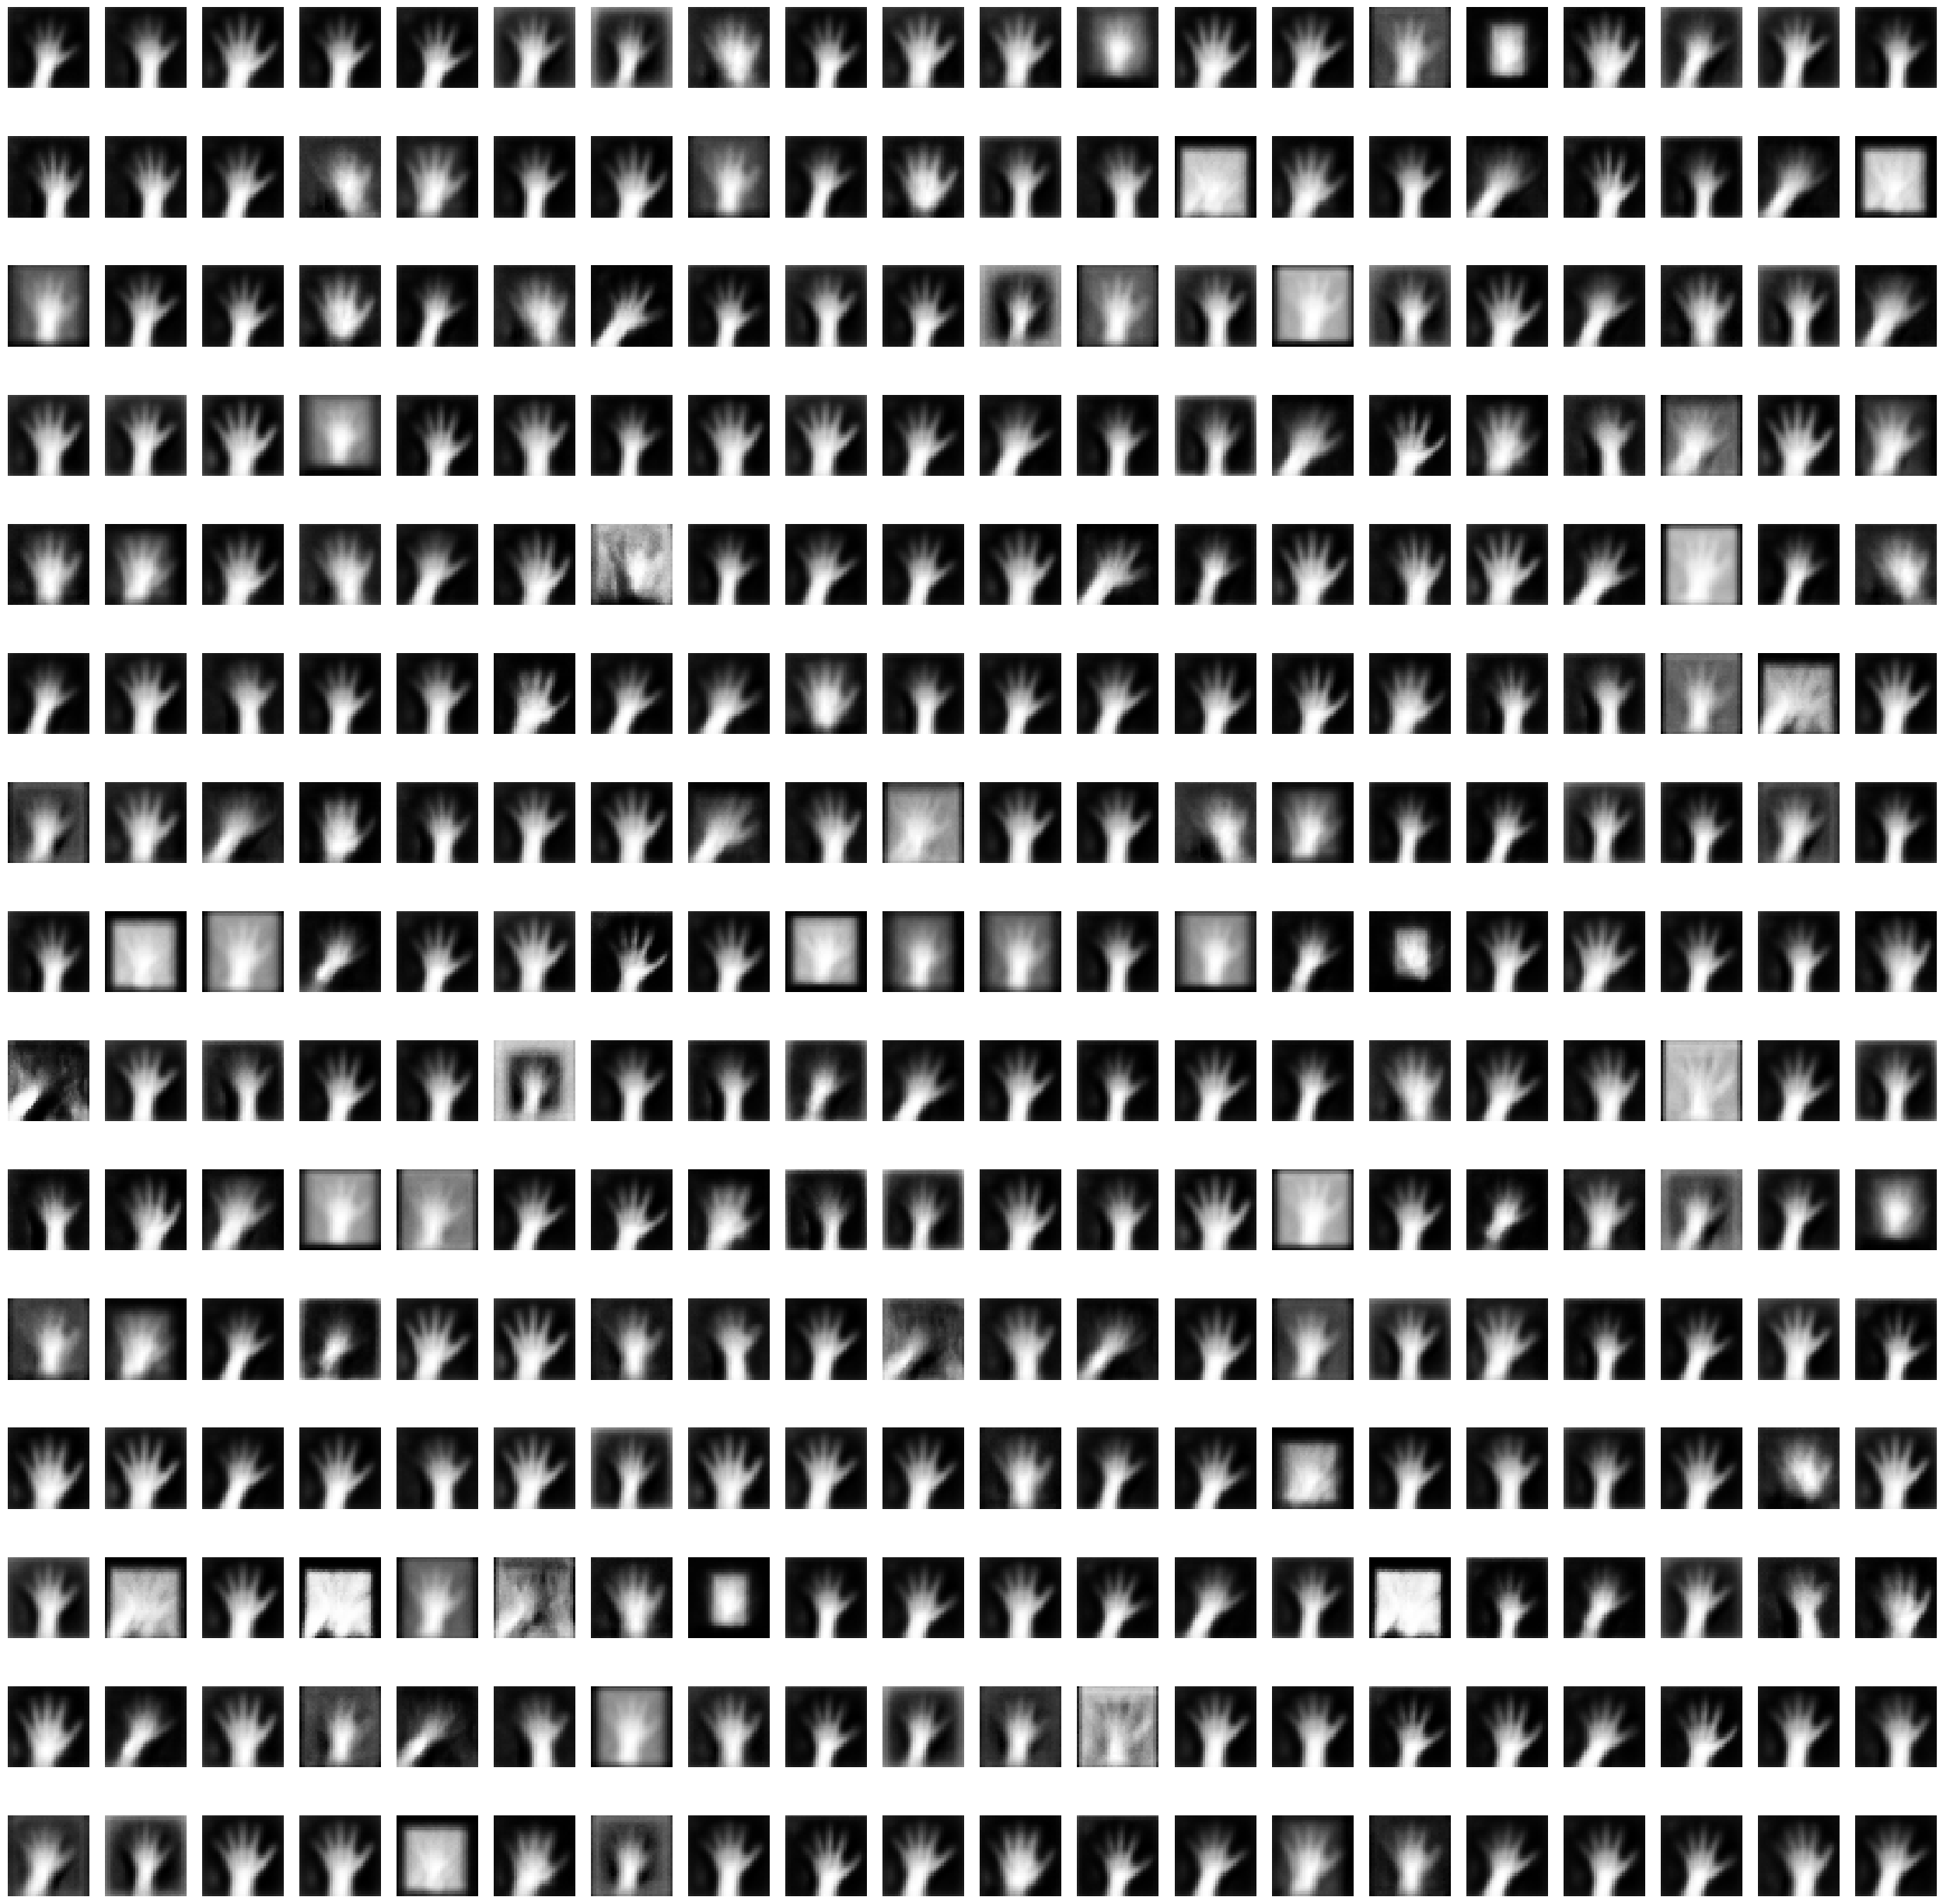

In [23]:
def plot_samples(autoencoder, num_samples=300):
    # Generate a random potential vector z
    z = torch.randn(num_samples, 3).to(device)

    # Decoding latent vectors to generate images
    imgs = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach()

    # Create a 15x20 subgraph grid
    fig, axes = plt.subplots(15, 20, figsize=(32, 32))

    # Filling the subgraph grid
    for i, ax in enumerate(axes.flatten()):
        # Display the ith image
        img = imgs[i][0]
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.show()

plot_samples(VAE)

## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

In [25]:
from PIL import Image

def save_samples(autoencoder, num_samples=300, save_dir='/content/drive/MyDrive/dlmodule-coursework-1-acse-fh223/testimg/'):
    # Generate a random latent vector z
    z = torch.randn(num_samples, 3).to(device)

    # Decoding latent vectors to generate images
    imgs = autoencoder.decoder(autoencoder.activationOut(autoencoder.latentOut(z))).to('cpu').detach()

    for i in range(num_samples):
        img = imgs[i][0]
        img = img.numpy()

        # Normalize the image to 0-255 and convert to 'L' for grayscale
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
        pil_img = Image.fromarray(img, 'L')

        # Save the image
        filename = f"{save_dir}acse-fh223_VAE{str(i + 1).zfill(3)}.jpeg"
        pil_img.save(filename)

# Assuming VAE is your autoencoder model instance
save_samples(VAE)
